In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors

In [2]:
spark=SparkSession.builder.appName('data_processing').getOrCreate()
df = spark.read.csv(r'C:\Users\REGGIE\Desktop\student\数据分析资料\Spark学习\data\profile_bank.csv',inferSchema=True,header=True)

In [3]:
df

DataFrame[ID: int, CNT_TBM: int, CNT_ATM: int, CNT_POS: int, CNT_CSC: int, CNT_TOT: int]

In [38]:
#特征处理
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.linalg import Vectors

from pyspark.ml.feature import VectorAssembler
VectorAssembler = VectorAssembler(inputCols=["CNT_TBM","CNT_ATM","CNT_POS","CNT_CSC"],outputCol="features")
new_df=VectorAssembler.transform(df)

In [39]:
#建立模型
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
kmeans=KMeans(k=4,seed=1)
model=kmeans.fit(new_df.select('features'))
predict = model.transform(new_df)
centers=model.clusterCenters()
#modelcost=model.computeCost()

In [40]:
#查看其分类结果
predict.select('prediction').distinct().show()

+----------+
|prediction|
+----------+
|         1|
|         3|
|         2|
|         0|
+----------+



In [41]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predict)
print("Silhouette with squared euclidean distance = " + str(silhouette))
 
# 打印中心点Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.6985935381289298
Cluster Centers: 
[44.80981557 18.57897332 10.38080034  5.63666847]
[1.4934e+04 5.7000e+01 2.0000e+00 2.3200e+02]
[164.40445151  23.45802862  18.56136725  11.14674086]
[4.74284615e+03 1.60769231e+01 2.00000000e+00 4.73846154e+01]


In [36]:
#sklearn中的kmeans

In [37]:
import pandas as pd
model_data = pd.read_csv(r'C:\Users\REGGIE\Desktop\student\数据分析资料\Spark学习\data\profile_bank.csv')
data = model_data.loc[ :,'CNT_TBM':'CNT_CSC']
data.head()

,CNT_TBM,CNT_ATM,CNT_POS,CNT_CSC
0,34,3,3,9
1,44,17,5,18
2,122,26,32,36
3,42,3,6,1
4,20,15,2,2


In [45]:
#做主成分之前，进行中心标准化
from sklearn import preprocessing
data = preprocessing.scale(data)

In [46]:
#使用sklearn的主成分分析，用于判断保留主成分的数量
from sklearn.decomposition import PCA
'''说明：1、第一次的n_components参数应该设的大一点
   说明：2、观察explained_variance_ratio_和explained_variance_的取值变化，建议explained_variance_ratio_累积大于0.85，explained_variance_需要保留的最后一个主成分大于0.8，
'''
pca=PCA(n_components=4)
newData=pca.fit(data)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[1.60786876 1.00252275 0.7339482  0.65570029]
[0.40196317 0.25062818 0.18348521 0.16392343]


In [47]:
#通过主成分在每个变量上的权重的绝对值大小，确定每个主成分的代表性
pd.DataFrame(pca.components_).T

,0,1,2,3
0,0.303020,0.834245,0.445132,0.118622
1,0.555131,-0.377566,0.135542,0.728630
2,0.559520,-0.315486,0.386716,-0.661708
3,0.535673,0.248894,-0.796201,-0.131035


In [49]:
## 第二步：根据主成分分析确定需要保留的主成分数量，进行因子分析
# - 1、导入包，并对输入的数据进行主成分提取。为保险起见，data需要进行中心标准化
from fa_kit import FactorAnalysis
from fa_kit import plotting as fa_plotting
fa = FactorAnalysis.load_data_samples(
        data,
        preproc_demean=True,
        preproc_scale=True
        )
fa.extract_components()

In [50]:
# 设定提取主成分的方式。默认为“broken_stick”方法，建议使用“top_n”法
fa.find_comps_to_retain(method='top_n',num_keep=3)

array([0, 1, 2], dtype=int64)

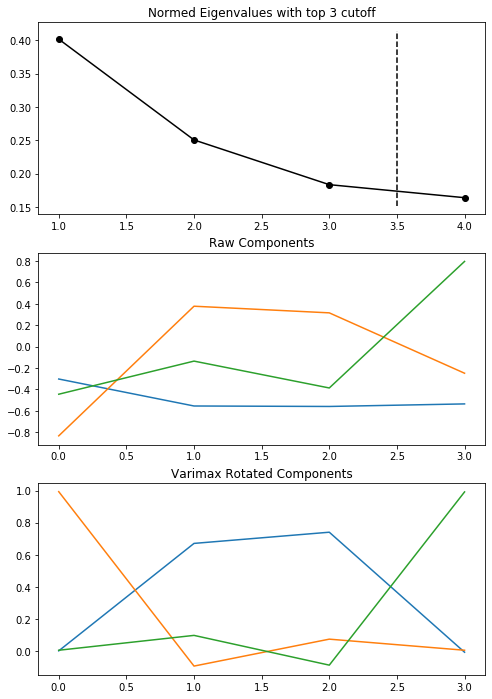

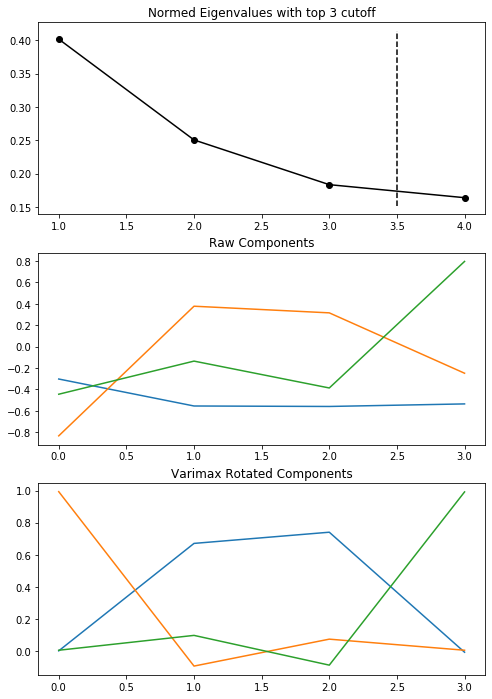

In [63]:
#通过最大方差法进行因子旋转
fa.rotate_components(method='varimax')
fa_plotting.graph_summary(fa)
# - 说明：可以通过第三张图观看每个因子在每个变量上的权重，权重越高，代表性越强
#选择三个主成分即可，所以num_keep = 3

In [65]:
#获取因子得分
pd.DataFrame(fa.comps["rot"])

,0,1,2
0,0.004039,0.992900,0.007811
1,0.671476,-0.090569,0.100081
2,0.741002,0.076706,-0.084707
3,-0.004504,0.007874,0.991336


In [67]:
import numpy as np
fas = pd.DataFrame(fa.comps["rot"])
data = pd.DataFrame(data)
score = pd.DataFrame(np.dot(data, fas))
score.head()

,0,1,2
0,-0.852354,-0.294938,0.143935
1,-0.333078,-0.244334,0.939343
2,0.918067,0.593787,2.349496
3,-0.741847,-0.210507,-0.521592
4,-0.499703,-0.492714,-0.367629


In [60]:
fa_scores=score.rename(columns={0: "ATM_POS", 1: "TBM", 2: "CSC"})
fa_scores.head()

,ATM_POS,TBM,CSC
0,-0.852354,-0.294938,0.143935
1,-0.333078,-0.244334,0.939343
2,0.918067,0.593787,2.349496
3,-0.741847,-0.210507,-0.521592
4,-0.499703,-0.492714,-0.367629


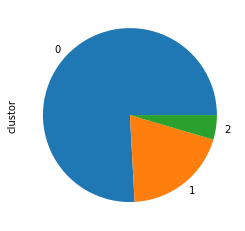

In [61]:
#使用因子得分进行k-means聚类
# ### 4.1 k-means聚类的第一种方式：不进行变量分布的正态转换--用于寻找异常值

# - 1、查看变量的偏度
var = ["ATM_POS","TBM","CSC"]
skew_var = {}
for i in var:
    skew_var[i]=abs(fa_scores[i].skew())
    skew=pd.Series(skew_var).sort_values(ascending=False)
skew

# - 2、进行k-means聚类
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3) #MiniBatchKMeans()分批处理
#kmeans = cluster.KMeans(n_clusters=3, init='random', n_init=1)
result=kmeans.fit(fa_scores)
#print(result)


# - 3、对分类结果进行解读

model_data_l=model_data.join(pd.DataFrame(result.labels_))
model_data_l=model_data_l.rename(columns={0: "clustor"})
model_data_l.head()


import matplotlib
get_ipython().magic('matplotlib inline')
model_data_l.clustor.value_counts().plot(kind = 'pie') 

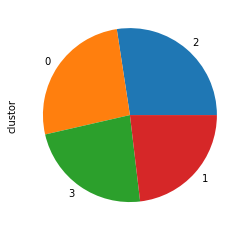

In [62]:
# ### 4.2 k-means聚类的第二种方式：进行变量分布的正态转换--用于客户细分

# - 1、进行变量分布的正态转换
from sklearn import preprocessing
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
fa_scores_trans=quantile_transformer.fit_transform(fa_scores)
fa_scores_trans=pd.DataFrame(fa_scores_trans)
fa_scores_trans=fa_scores_trans.rename(columns={0: "ATM_POS", 1: "TBM", 2: "CSC"})
fa_scores_trans.head()


var = ["ATM_POS","TBM","CSC"]
skew_var = {}
for i in var:
    skew_var[i]=abs(fa_scores_trans[i].skew())
    skew=pd.Series(skew_var).sort_values(ascending=False)
skew

# - 2、进行k-means聚类
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4) #MiniBatchKMeans()分批处理
#kmeans = cluster.KMeans(n_clusters=3, init='random', n_init=1)
result=kmeans.fit(fa_scores_trans)
#print(result)


# - 3、对分类结果进行解读
model_data_l=model_data.join(pd.DataFrame(result.labels_))
model_data_l=model_data_l.rename(columns={0: "clustor"})
model_data_l.head()

import matplotlib
get_ipython().magic('matplotlib inline')
model_data_l.clustor.value_counts().plot(kind = 'pie') 